In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from x_transformers import ViTransformerWrapper, Encoder
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomResizedCrop, CenterCrop, Resize, Normalize, Compose

/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)


In [2]:
train_dataset = load_dataset("imagenet-1k",split="train",trust_remote_code=True)
valid_dataset = load_dataset("imagenet-1k",split="validation",trust_remote_code=True)
rgb_train = train_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")
rgb_valid = valid_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [3]:
vit = ViTransformerWrapper(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    attn_layers = Encoder(
        dim = 512,
        depth = 6,
        heads = 8,
    )
).cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=0.001)

In [4]:
def custom_collate_fn(batch):
    transform = Compose([
        RandomResizedCrop(256, antialias=True),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images = torch.stack([transform(item['image'].permute(2, 0, 1).float()) for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.int64)
    return images, labels

Epoch: 1, Accuracy: 0.0262


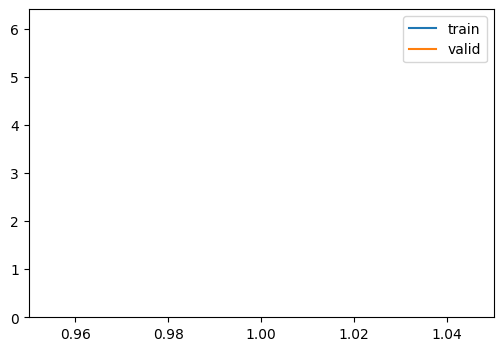

/home/dgj335/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


In [ ]:
epochs = 100
mb = master_bar(range(1, epochs + 1))
train_loss = []
test_loss = []
val_accuracy = []
batch_size = 1024
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
rr_crop = RandomResizedCrop(256,antialias=True);
resize = Resize(256, antialias=True)
center_crop = CenterCrop(256)
for epoch in mb:
    
    dataloader_train = DataLoader(rgb_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, collate_fn=custom_collate_fn)
    dataloader_valid = DataLoader(rgb_valid, batch_size=1, shuffle=False, drop_last=False)

    # Training
    vit.train()
    running_loss = 0.0
    for x,target in progress_bar(dataloader_train, parent=mb):
        
        optimizer.zero_grad()
        outputs = vit(x.cuda())
        loss = loss_function(outputs, target.cuda())
        if torch.isnan(loss):
            print(f"Loss is nan, skipping batch")
            continue
        loss.backward()
        print(loss.item(), end='\r')
        optimizer.step()
        running_loss += loss.item()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation
    vit.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_valid:
            x = inputs['image'].to(torch.float32).permute(0,3,1,2)
            x = normalize(center_crop(resize(x))).cuda()
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = vit(x)
            loss = loss_function(outputs, targets)
            if torch.isnan(loss):
                print(f"Loss is nan, skipping batch")
                continue
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_valid)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    checkpoint_filename = f'simplevit_imagenet1k_checkpoint{epoch}.pt'
    torch.save(vit.state_dict(), checkpoint_filename)